In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import VotingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
import catboost as cb
import xgboost as xgb
from scipy.stats import probplot, ks_2samp

from View import MyClass

In [2]:
def sub(model, test,  test_id, name_csv = "sumnission_answer"):
    pred = model.predict_proba(test)
    pred = pred[:,1]
    answer = pd.DataFrame()
    answer['id'] = test_id
    answer['defects'] = pred
    if os.path.isdir("submit") == False:
        os.mkdir("submit")
    answer.to_csv(f"submit/{name_csv}.csv", index=False)

In [19]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=5000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", -2, 3) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        auc_score = roc_auc_score(y_true, weighted_pred)
        log_loss_score=log_loss(y_true, weighted_pred)
        return auc_score#/log_loss_score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [3]:
os.listdir("data")

['sample_submission.csv', 'test.csv', 'train.csv']

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

In [5]:
mc = MyClass()

In [6]:
print(mc.__doc__)

Визуализация и предобработка данных
# Первичный обзор
* Метод "view_csv" принимает DataFrame и выводит данные о нем, переводит название столбцов в lower
возвращает data.columns, categorical, numerical

# Статистика
* Метод "stat_frame" принимает DataFrame и возвращает DataFrame со статистиками
* Метод "corr" принимает DataFrame и target : str
* Метод corr_sign принимает data: DataFrame, drop_sign:List ( корреляция между признаками)
* Метод nonlianer_comun принимает data: DataFrame, numerical: list(список числовых признаков
target: str(по умолчанию "class"), num_sign: int(кол-во столбцов с нелинейной связью)
* Метод "percentile_99_1" принимает data: DataFrame, data_stat : DataFrame( возвращает метод "stat_frame"), flag: bool(
если флаг равен True возвращает фрейм где максимум заменен на 99 перцентиль, а минимум на 1 перцентиль)
по умолчанию flag = False
возвращат данные где больше 99 перцетиля и меньше 1(используется метод for, не рекомендуется где очень много столбцов)

# Работа с данн

In [7]:
train.columns, category, numerical = mc.view_csv(train)
test.columns, category_t, numerical_t = mc.view_csv(test)

rows: 101763, cols: 23
Всего категориальных признаков: 0
Index([], dtype='object')
Всего числовых признаков: 23
['locomment', 'locode', 'b', 'uniq_op', 'defects', 't', 'n', 'total_op', 'loc', 'id', 'e', 'v', 'iv(g)', 'l', 'loccodeandcomment', 'v(g)', 'loblank', 'ev(g)', 'i', 'uniq_opnd', 'total_opnd', 'branchcount', 'd']
В данных пропусков нету
rows: 67842, cols: 22
Всего категориальных признаков: 0
Index([], dtype='object')
Всего числовых признаков: 22
['locomment', 'locode', 'b', 'uniq_op', 't', 'n', 'total_op', 'loc', 'id', 'e', 'v', 'iv(g)', 'l', 'loccodeandcomment', 'v(g)', 'loblank', 'ev(g)', 'i', 'uniq_opnd', 'total_opnd', 'branchcount', 'd']
В данных пропусков нету


In [8]:
train.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,locode,locomment,loblank,loccodeandcomment,uniq_op,uniq_opnd,total_op,total_opnd,branchcount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [9]:
train = train.drop('id', axis=1)

In [10]:
train['defects'] = train['defects'].astype(int)

In [11]:
submission.sample()

,id,defects
61669,163432,0.5


In [12]:
test_id = test["id"]
test = test.drop('id', axis=1)

# base line

In [36]:
cb_params = {
    "n_estimators": 2000,
    'subsample': 0.7,
    'max_depth': 4,
    'leaf_estimation_iterations': 50,
    'l2_leaf_reg': 2,
    "learning_rate": 0.008826816129789937,
    'colsample_bylevel': 0.3,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": False,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 45,
    "class_weights":(1,3)
}

params_xgb = {
    "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "nthread": 6,
    "seed": 27
    }

In [14]:
78699/23064

3.412200832466181

In [15]:
train['defects'].value_counts()

0    78699
1    23064
Name: defects, dtype: int64

In [37]:
x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(train, "defects", RandomState=45)

x_train.shape: (65128, 21) x_valid.shape:  (20353, 21) y_train.shape:  (65128,) y_valid.shape:  (20353,) x_test.shape:  (16282, 21) y_test.shape:  (16282,)


In [38]:
model_cb, rauc = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=cb_params)

[]
roc_auc_score:  0.7268902873190594
confusion_matrix:  [[12693  3011]
 [ 1648  3001]]
accuracy_score:  0.7710902569645752


In [39]:
pred = model_cb.predict_proba(x_valid)[:,1]

In [33]:
oof_pred = list()

In [40]:
oof_pred.append(pred)

In [43]:
import optuna
from functools import partial
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score

In [41]:
oof_pred

[array([0.68089435, 0.17237487, 0.40938641, ..., 0.74190991, 0.81112211,
        0.17667164]),
 array([0.16366682, 0.32833012, 0.18965417, ..., 0.70360892, 0.16559858,
        0.52292172])]

In [44]:
# Use Optuna to find the best ensemble weights
optweights = OptunaWeights(random_state=42)
y_val_pred = optweights.fit_predict(y_valid.values, oof_pred)

In [45]:
y_val_pred

array([0.16553725, 0.32776615, 0.19044878, ..., 0.70374743, 0.16793297,
       0.52166959])

In [ ]:
# Use Optuna to find the best ensemble weights
optweights = OptunaWeights(random_state=random_state)
y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    
    score = roc_auc_score(y_val, y_val_pred)
#     score = accuracy_score(y_val, acc_cutoff_class(y_val, y_val_pred))
    print(f'Ensemble [FOLD-{i}] ------------------>  ROC AUC score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    
    test_predss += optweights.predict(test_preds) / (n_splits)

# 0.78935

In [30]:
sub(model_cb, test, test_id, "baseline")

In [31]:
model_cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,loc,31.796939
1,loblank,13.955498
2,locode,4.986098
3,l,4.715712
4,v,4.225013
5,uniq_opnd,3.939488
6,branchcount,3.106050
7,v(g),2.966239
8,b,2.962351
9,uniq_op,2.815902


In [32]:
train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

In [33]:
x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(train, "defects", RandomState=0)

x_train.shape: (65128, 21) x_valid.shape:  (20353, 21) y_train.shape:  (65128,) y_valid.shape:  (20353,) x_test.shape:  (16282, 21) y_test.shape:  (16282,)


In [34]:
model_cb, rauc = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=cb_params)

[]
roc_auc_score:  0.6689870252457089
confusion_matrix:  [[14817   936]
 [ 2772  1828]]
accuracy_score:  0.8178155554463715


In [35]:
sub(model_cb, test, test_id, "baseline")

In [36]:
train.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,locode,locomment,loblank,loccodeandcomment,uniq_op,uniq_opnd,total_op,total_opnd,branchcount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,1
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,0


In [37]:
model_rf = mc.forest_base(x_train, x_valid, y_train, y_valid)

roc_auc_score:  0.6661079256125126
confusion_matrix:  [[14853   900]
 [ 2809  1791]]
accuracy_score:  0.817766422640397


In [38]:
sub(model_rf, test, test_id, "baseline")

# find anomalies

In [13]:
from sklearn.ensemble import IsolationForest

In [27]:
train.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'locode', 'locomment', 'loblank', 'loccodeandcomment', 'uniq_op',
       'uniq_opnd', 'total_op', 'total_opnd', 'branchcount', 'defects'],
      dtype='object')

In [30]:
iso_forest = IsolationForest(n_estimators=100, contamination='auto', max_features=len(train.drop("defects", axis=1).columns), n_jobs=-1)
iso_forest.fit(train.drop("defects", axis=1))
# >>> IsolationForest(behaviour='deprecated', bootstrap=False,
#                 contamination=0.09090909090909091, max_features=100,
#                 max_samples='auto', n_estimators=100, n_jobs=-1,
#                 random_state=None, verbose=0, warm_start=False)

IsolationForest(max_features=21, n_jobs=-1)

In [32]:
iso_forest_prediction = iso_forest.predict(train.drop("defects", axis=1))
iso_forest_prediction_test = iso_forest.predict(test)

In [33]:
(iso_forest_prediction == -1).sum(), (iso_forest_prediction_test == -1).sum()

(9299, 6291)

In [35]:
train.shape, test.shape

((101763, 22), (67842, 21))

In [18]:
len(iso_forest_prediction)

101763

In [36]:
cont_cols = [f for f in train.columns if pd.api.types.is_numeric_dtype(train[f]) and train[f].nunique() / train.shape[0] * 100 > 2.5]
cat_cols = [f for f in train.columns if train[f].nunique() / train.shape[0] * 100 <= 5\
            and f not in ['defects']]

In [45]:
cat_cols

['loc',
 'v(g)',
 'ev(g)',
 'iv(g)',
 'n',
 'v',
 'l',
 'd',
 'b',
 'locode',
 'locomment',
 'loblank',
 'loccodeandcomment',
 'uniq_op',
 'uniq_opnd',
 'total_op',
 'total_opnd',
 'branchcount']

# статистика

In [101]:
stat_data = mc.stat_frame(train)

In [102]:
stat_data

,count,max,quantile_99,max_vs_quantile_99,min,quantile_1,min_vs_quantile_1,nunique,isna_sum,dtype
loc,101763,3442.0,226.0,1011,1.0,4.0,24,378,0,float64
v(g),101763,404.0,33.38,1018,1.0,1.0,0,106,0,float64
ev(g),101763,165.0,23.0,855,1.0,1.0,0,71,0,float64
iv(g),101763,402.0,19.0,963,1.0,1.0,0,84,0,float64
n,101763,8441.0,756.0,1017,0.0,0.0,0,836,0,float64
v,101763,80843.08,5033.79,1014,0.0,0.0,0,4515,0,float64
l,101763,1.0,0.5,360,0.0,0.0,0,55,0,float64
d,101763,418.2,62.37,1017,0.0,0.0,0,3360,0,float64
i,101763,569.78,107.69,1012,0.0,0.0,0,5171,0,float64
e,101763,16846621.12,263719.21,1013,0.0,0.0,0,8729,0,float64


In [103]:
# замена на 99 перцентиля на макс, 1 min
data = train.copy()
for col in data.columns:
    data.loc[data[col] > data[col].quantile(0.99), col] = data[col].quantile(0.99)
    

In [104]:
mc.stat_frame(data)

,count,max,quantile_99,max_vs_quantile_99,min,quantile_1,min_vs_quantile_1,nunique,isna_sum,dtype
loc,101763,226.0,226.0,0,1.0,4.0,24,222,0,float64
v(g),101763,33.38,33.1444,1018,1.0,1.0,0,34,0,float64
ev(g),101763,23.0,23.0,0,1.0,1.0,0,23,0,float64
iv(g),101763,19.0,19.0,0,1.0,1.0,0,19,0,float64
n,101763,756.0,756.0,0,0.0,0.0,0,630,0,float64
v,101763,5033.79,5033.79,0,0.0,0.0,0,4278,0,float64
l,101763,0.5,0.5,0,0.0,0.0,0,50,0,float64
d,101763,62.37,62.37,0,0.0,0.0,0,3112,0,float64
i,101763,107.69,107.69,0,0.0,0.0,0,4885,0,float64
e,101763,263719.21,263719.21,0,0.0,0.0,0,8479,0,float64


In [17]:
x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(data, "defects", RandomState=0)
# model, auc = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=cb_params)
# sub(model, test, test_id, "baseline")

x_train.shape: (65128, 21) x_valid.shape:  (20353, 21) y_train.shape:  (65128,) y_valid.shape:  (20353,) x_test.shape:  (16282, 21) y_test.shape:  (16282,)


In [66]:
model, auc = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=cb_params)
# sub(model, test, test_id, "baseline")

[]
roc_auc_score:  0.7240682865099539
confusion_matrix:  [[12734  3019]
 [ 1657  2943]]
accuracy_score:  0.7702549992630079


In [67]:
sub(model, test, test_id, "baseline")

In [78]:
ensemble = VotingClassifier(
    [('cb', cb.CatBoostClassifier(**cb_params)),
     ('rf', RandomForestClassifier(
            n_estimators=250, max_depth=20, n_jobs=6, max_leaf_nodes=93, random_state=0
        )),
     ('lr', make_pipeline(StandardScaler(),
                           LogisticRegression(penalty ="l1",
                                              solver='liblinear',
                                              C=100,
                                              max_iter=100)))
    ],
    voting='soft',
    weights=[0.5, 0.2, 0.3]
)

# auc = cross_val(ensemble, 'Ensemble(HGB+RF+KNN)')

In [32]:
ensemble.fit(x_train, y_train)
# pred = ensemble.predict(x_valid)
# roc_auc_score(y_valid, pred)

VotingClassifier(estimators=[('cb',
                              <catboost.core.CatBoostClassifier object at 0x00000220131A8E48>),
                             ('rf',
                              RandomForestClassifier(max_depth=20,
                                                     max_leaf_nodes=93,
                                                     n_estimators=250, n_jobs=6,
                                                     random_state=0)),
                             ('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=100,
                                                                  penalty='l1',
                                                                  solver='liblinear'))]))],
                 voting='soft')

In [33]:
pred = ensemble.predict(x_valid)

In [34]:
roc_auc_score(y_valid, pred)

0.6896785222414502

In [71]:
sub(ensemble, test, test_id, "ensemble")

# графики

defects              1.000000
loc                  0.436170
v(g)                 0.377110
branchcount          0.376755
iv(g)                0.368188
locode               0.324906
b                    0.316640
v                    0.315347
n                    0.314799
total_opnd           0.313647
total_op             0.311979
loblank              0.303741
uniq_opnd            0.295164
ev(g)                0.285307
e                    0.282013
t                    0.281975
d                    0.262524
locomment            0.242643
i                    0.224175
uniq_op              0.179485
loccodeandcomment    0.149407
l                   -0.259300
Name: defects, dtype: float64


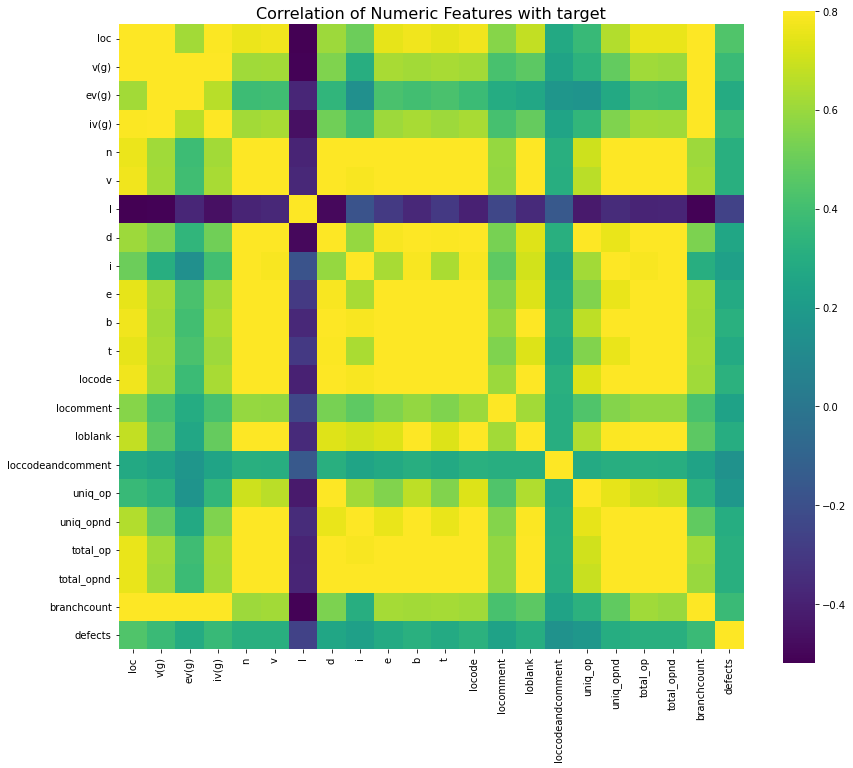

In [20]:
mc.corr(data, 'defects')

* много коррелирующих между собой признаков

In [58]:
data_drop = data.copy()
test_drop = test.copy()
data_drop = data_drop.drop(["v(g)", "n", "e", "t","b","l", "locode", "total_op", "total_opnd", "loblank"],axis=1)
test_drop = test_drop.drop(["v(g)", "n", "e", "t","b","l", "locode", "total_op", "total_opnd", "loblank"],axis=1)

defects              1.000000
loc                  0.436170
branchcount          0.376755
iv(g)                0.368188
v                    0.315347
uniq_opnd            0.295164
ev(g)                0.285307
d                    0.262524
locomment            0.242643
i                    0.224175
uniq_op              0.179485
loccodeandcomment    0.149407
Name: defects, dtype: float64


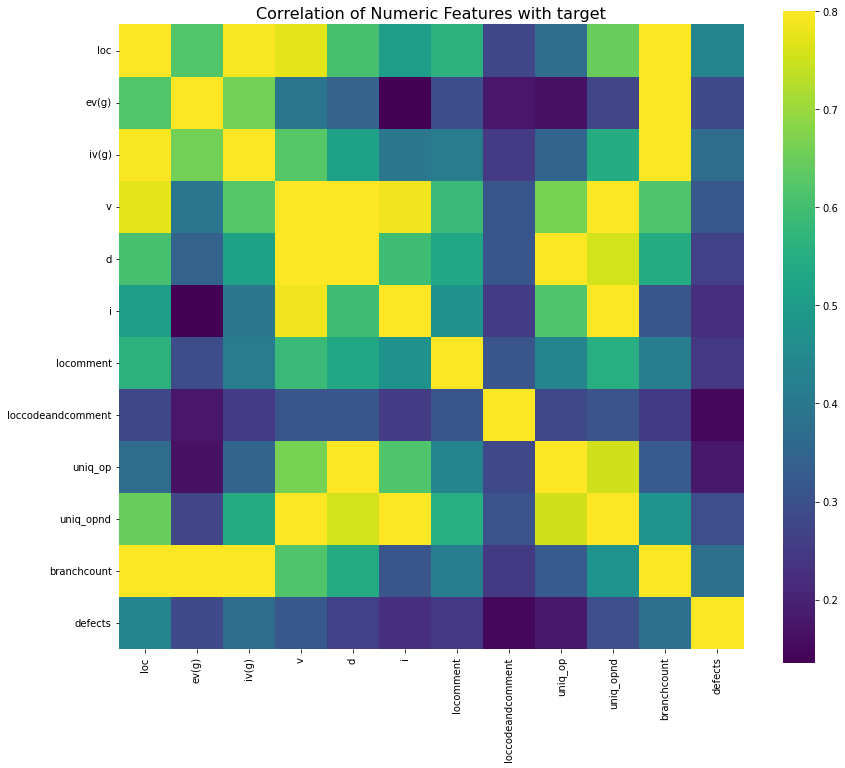

In [59]:
mc.corr(data_drop, 'defects')

In [60]:
x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(data_drop, "defects", RandomState=0)
model, auc = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=cb_params)
# sub(model, test, test_id, "baseline")

x_train.shape: (65128, 11) x_valid.shape:  (20353, 11) y_train.shape:  (65128,) y_valid.shape:  (20353,) x_test.shape:  (16282, 11) y_test.shape:  (16282,)
[]
roc_auc_score:  0.7258987384045551
confusion_matrix:  [[12754  2999]
 [ 1646  2954]]
accuracy_score:  0.7717781162482189


In [23]:
sub(model, test_drop, test_id, "drop_corr_no_sub")

# oof

In [61]:
oof_cb = model.predict_proba(data_drop)[:,1]
oof_cb_t = model.predict_proba(test_drop)[:,1]

In [62]:
model_xgb= mc.xgb_base(x_train, x_valid, y_train, y_valid, params=params_xgb)

[0]	dtrain-auc:0.78826	dvalid-auc:0.78800
[1]	dtrain-auc:0.78858	dvalid-auc:0.78846
[2]	dtrain-auc:0.78871	dvalid-auc:0.78844
[3]	dtrain-auc:0.78883	dvalid-auc:0.78853
[4]	dtrain-auc:0.78883	dvalid-auc:0.78857
[5]	dtrain-auc:0.78885	dvalid-auc:0.78859
[6]	dtrain-auc:0.78904	dvalid-auc:0.78867
[7]	dtrain-auc:0.78909	dvalid-auc:0.78875
[8]	dtrain-auc:0.78925	dvalid-auc:0.78867
[9]	dtrain-auc:0.78998	dvalid-auc:0.78932
[10]	dtrain-auc:0.78994	dvalid-auc:0.78916
[11]	dtrain-auc:0.79018	dvalid-auc:0.78934
[12]	dtrain-auc:0.79039	dvalid-auc:0.78957
[13]	dtrain-auc:0.79045	dvalid-auc:0.78944
[14]	dtrain-auc:0.79051	dvalid-auc:0.78959
[15]	dtrain-auc:0.79095	dvalid-auc:0.78989
[16]	dtrain-auc:0.79108	dvalid-auc:0.78980
[17]	dtrain-auc:0.79110	dvalid-auc:0.78983
[18]	dtrain-auc:0.79120	dvalid-auc:0.78989
[19]	dtrain-auc:0.79119	dvalid-auc:0.78997
[20]	dtrain-auc:0.79139	dvalid-auc:0.78999
[21]	dtrain-auc:0.79150	dvalid-auc:0.79005
[22]	dtrain-auc:0.79151	dvalid-auc:0.79003
[23]	dtrain-auc:0.791

In [66]:
data_dm = xgb.DMatrix(
            data_drop.drop("defects", axis=1)
        )

test_dm = xgb.DMatrix(
            test_drop
        )

In [73]:
oof_xg = model_xgb.predict(data_dm)
oof_xg_t = model_xgb.predict(test_dm)
oof_xg

array([0.32675436, 0.30016345, 0.2908754 , ..., 0.3322204 , 0.2908754 ,
       0.58684945], dtype=float32)

In [68]:
model_rf= mc.forest_base(x_train, x_valid, y_train, y_valid)

roc_auc_score:  0.665320104659154
confusion_matrix:  [[14859   894]
 [ 2818  1782]]
accuracy_score:  0.8176190242224733


In [71]:
oof_rf = model_rf.predict_proba(data_drop.drop("defects", axis=1))[:,1]
oof_rf_t = model_rf.predict_proba(test_drop)[:,1]
oof_rf

array([0.11287308, 0.0827647 , 0.07619572, ..., 0.13710191, 0.07819201,
       0.55699921])

In [74]:
data_drop['oof_cb'] = oof_cb
test_drop['oof_cb'] = oof_cb_t

data_drop['oof_xg'] = oof_xg
test_drop['oof_xg'] = oof_xg_t

data_drop['oof_rf'] = oof_rf
test_drop['oof_rf'] = oof_rf_t

defects              1.000000
oof_rf               0.494555
oof_xg               0.481513
oof_cb               0.468651
loc                  0.436170
branchcount          0.376755
iv(g)                0.368188
v                    0.315347
uniq_opnd            0.295164
ev(g)                0.285307
d                    0.262524
locomment            0.242643
i                    0.224175
uniq_op              0.179485
loccodeandcomment    0.149407
Name: defects, dtype: float64


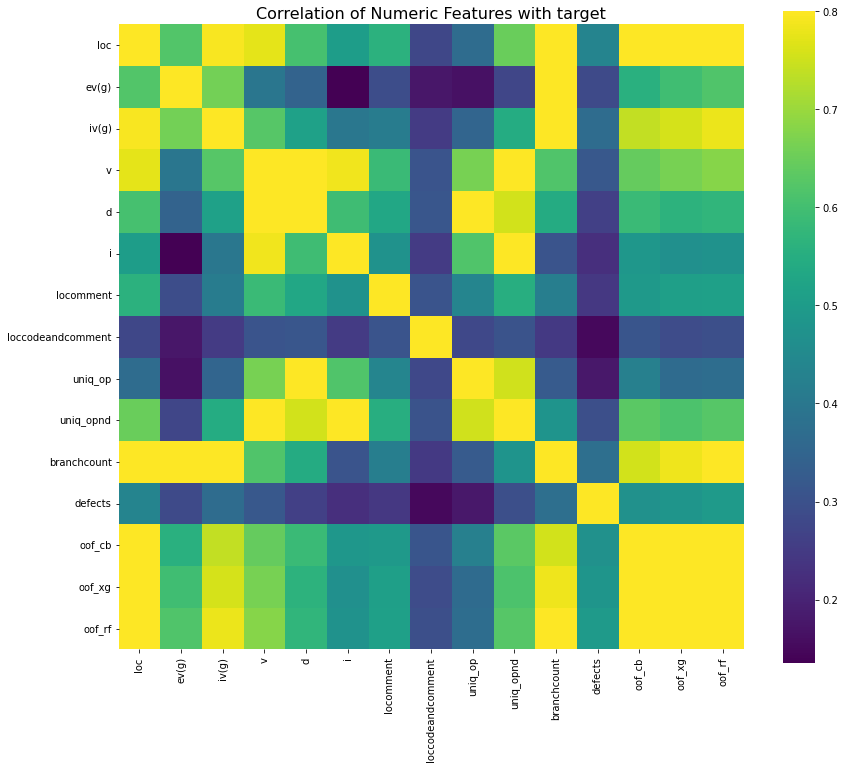

In [75]:
mc.corr(data_drop, 'defects')

In [76]:
x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(data_drop, "defects", RandomState=0)

x_train.shape: (65128, 14) x_valid.shape:  (20353, 14) y_train.shape:  (65128,) y_valid.shape:  (20353,) x_test.shape:  (16282, 14) y_test.shape:  (16282,)


In [79]:
ensemble.fit(x_train, y_train)
pred = ensemble.predict(x_valid)
roc_auc_score(y_valid, pred)

0.7003538732442958

In [81]:
sub(ensemble, test_drop, test_id, "ensemble_oof")

In [82]:
pipeline = make_pipeline(StandardScaler(),
                           LogisticRegression(penalty ="l1",
                                              solver='liblinear',
                                              C=100,
                                              max_iter=100))

In [83]:
pipeline.fit(x_train, y_train)
# pred_lr = pipeline.predict(x_valid)
# roc_auc_score(y_valid, pred_lr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=100, penalty='l1', solver='liblinear'))])

In [85]:
pred_lr = pipeline.predict(x_valid)
roc_auc_score(y_valid, pred_lr)

0.6688912532878485

In [86]:
sub(pipeline, test_drop, test_id, "lr_oof")

# only oof

In [87]:
data_drop.columns

Index(['loc', 'ev(g)', 'iv(g)', 'v', 'd', 'i', 'locomment',
       'loccodeandcomment', 'uniq_op', 'uniq_opnd', 'branchcount', 'defects',
       'oof_cb', 'oof_xg', 'oof_rf'],
      dtype='object')

In [88]:
data_oof = data_drop[['oof_cb', 'oof_xg', 'oof_rf', 'loc', "defects"]]
test_oof = test_drop[['oof_cb', 'oof_xg', 'oof_rf', 'loc']]

In [89]:
x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(data_oof, "defects", RandomState=0)

x_train.shape: (65128, 4) x_valid.shape:  (20353, 4) y_train.shape:  (65128,) y_valid.shape:  (20353,) x_test.shape:  (16282, 4) y_test.shape:  (16282,)


In [90]:
ensemble.fit(x_train, y_train)
pred = ensemble.predict(x_valid)
roc_auc_score(y_valid, pred)

0.6995507963976495

In [91]:
pipeline.fit(x_train, y_train)
pred_lr = pipeline.predict(x_valid)
roc_auc_score(y_valid, pred_lr)

0.6688056105255313

# continue graphics

{'loc': 0.32571589019053115, 'v(g)': 0.12249362602577467, 'v': 0.0037604847237700705, 'branchcount': 0.07873287543532444, 'iv(g)': 0.04339641002551988, 'locode': 0.0954756032774516, 'l': 0.06037575877036379, 'n': 0.010921149243740012, 'total_op': 0.009563513900150452, 'uniq_opnd': 0.007962746990390103, 'loblank': 0.0076540479012917806, 't': 0.011881010575194811, 'd': 0.06422404121685114, 'i': 0.0017277029466610553, 'e': 0.014280895398096204, 'b': 0.0006801384134779948, 'total_opnd': 0.004430641724262355, 'uniq_op': 0.023359487096124242, 'ev(g)': 0.028652950974349854, 'locomment': 0.005309616214159121, 'loccodeandcomment': 0.07940140895651526}


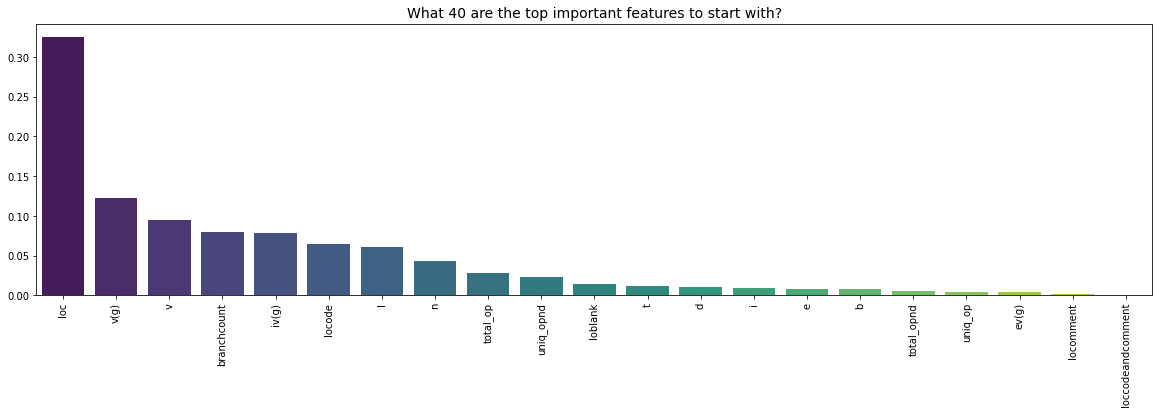

In [87]:
nonlianer_comun(data, data.columns, "defects", 40)

In [96]:
features = list(data.drop('defects', axis=1).columns)

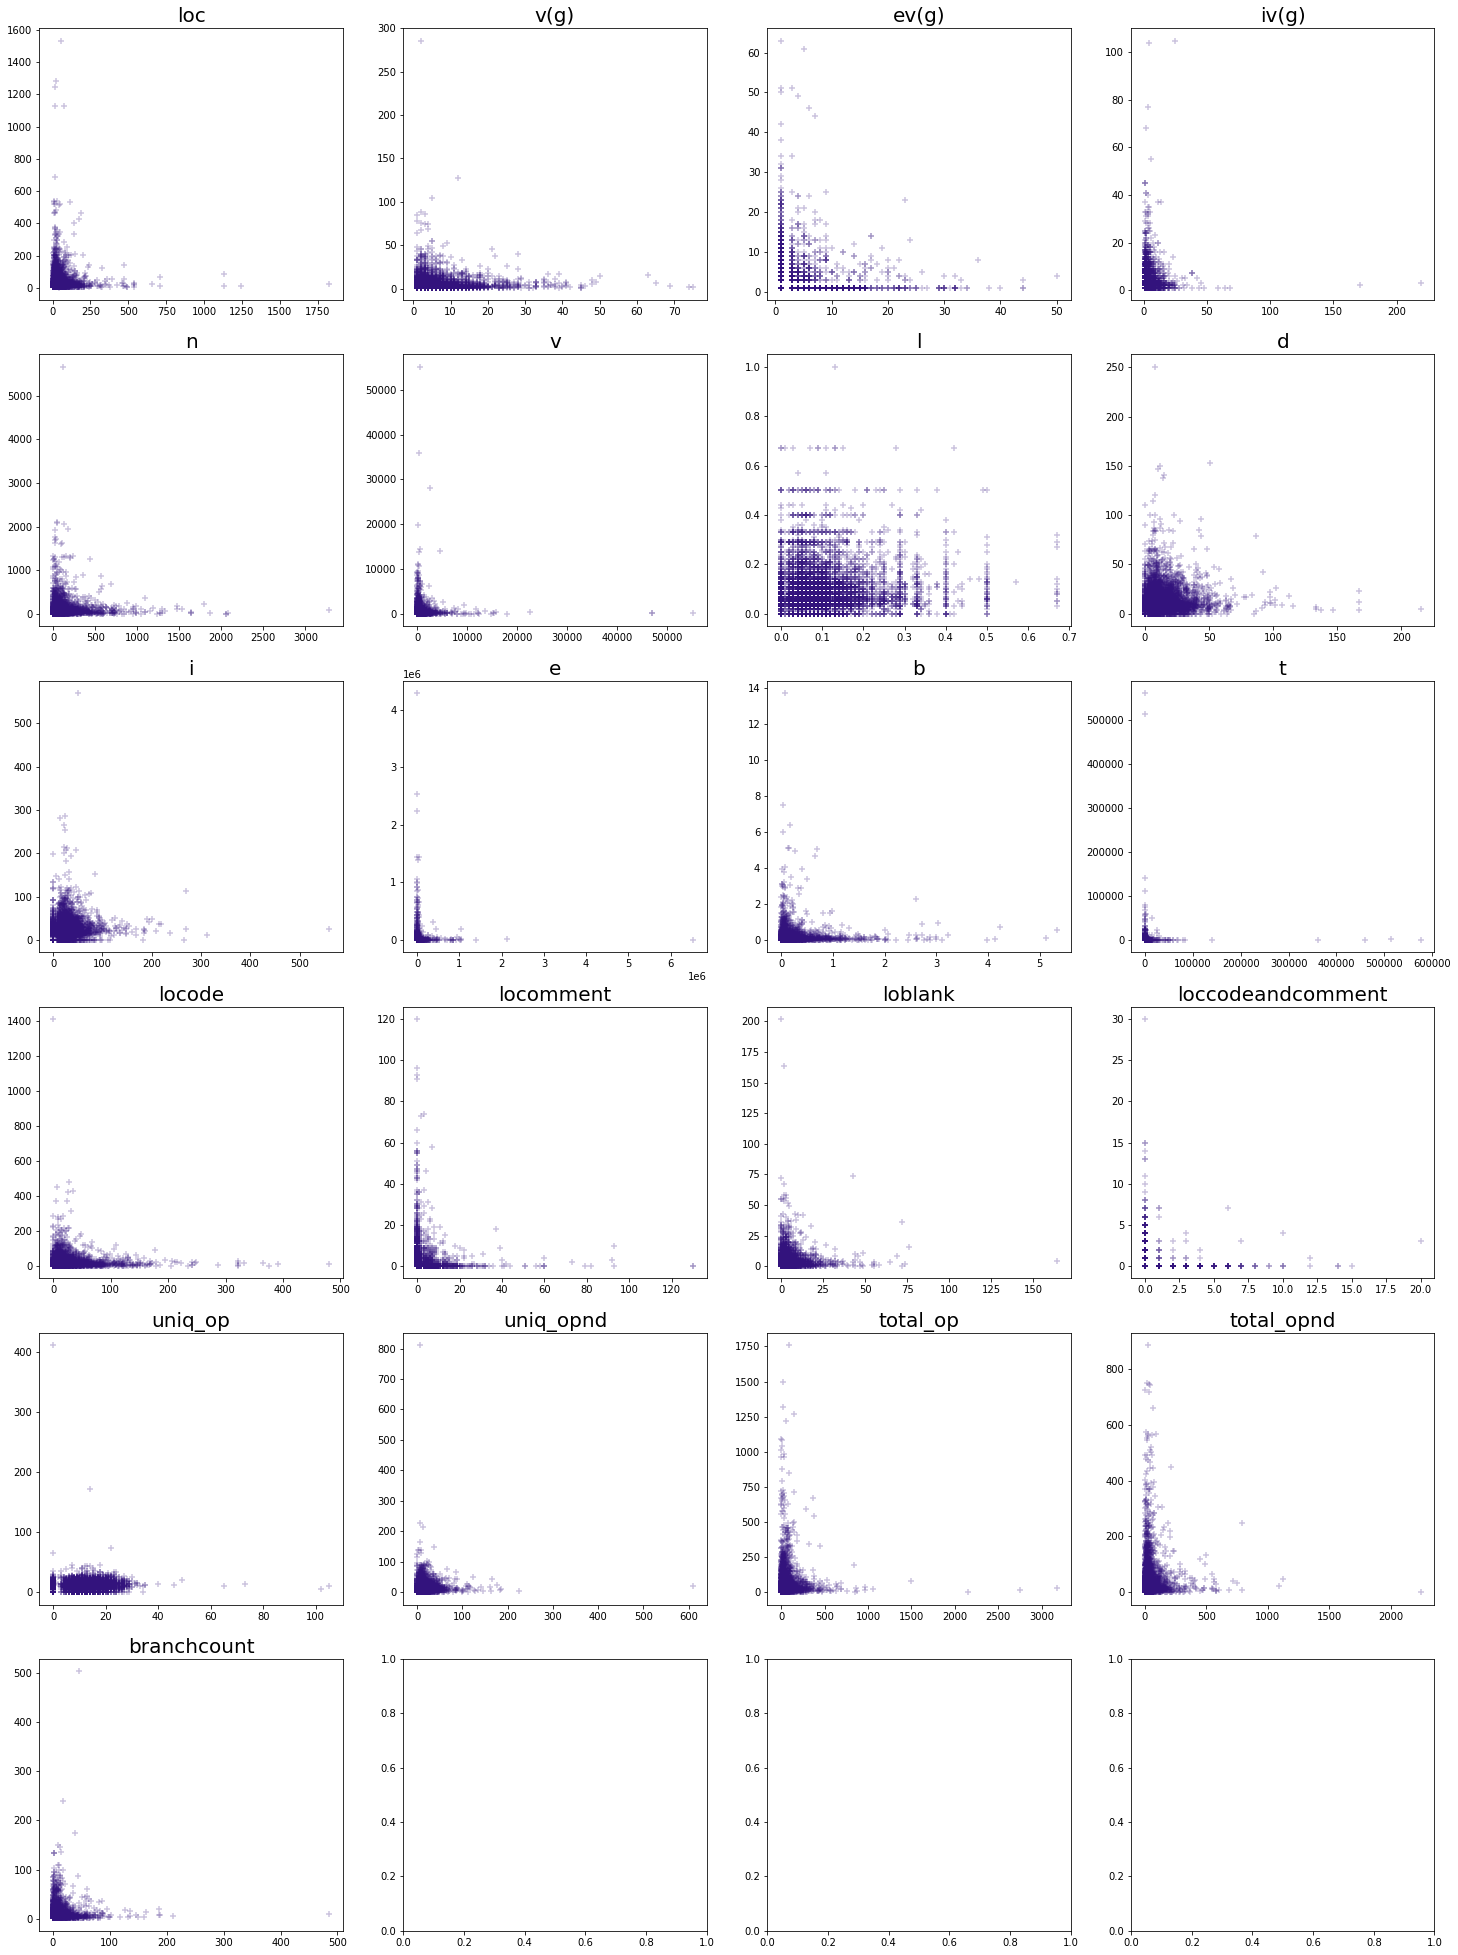

In [98]:
fig, axes = plt.subplots(6, 4, figsize=(25, 35))

for num, feature in enumerate(features, start=1):
    plt.subplot(6, 4, num)
    plt.title(f"{feature}", size=20)
    plt.scatter(
        train[feature].sample(5000).values,
        test[feature].sample(5000).values,
        color="#33137d",
        alpha=0.25,
        marker="+"
    )

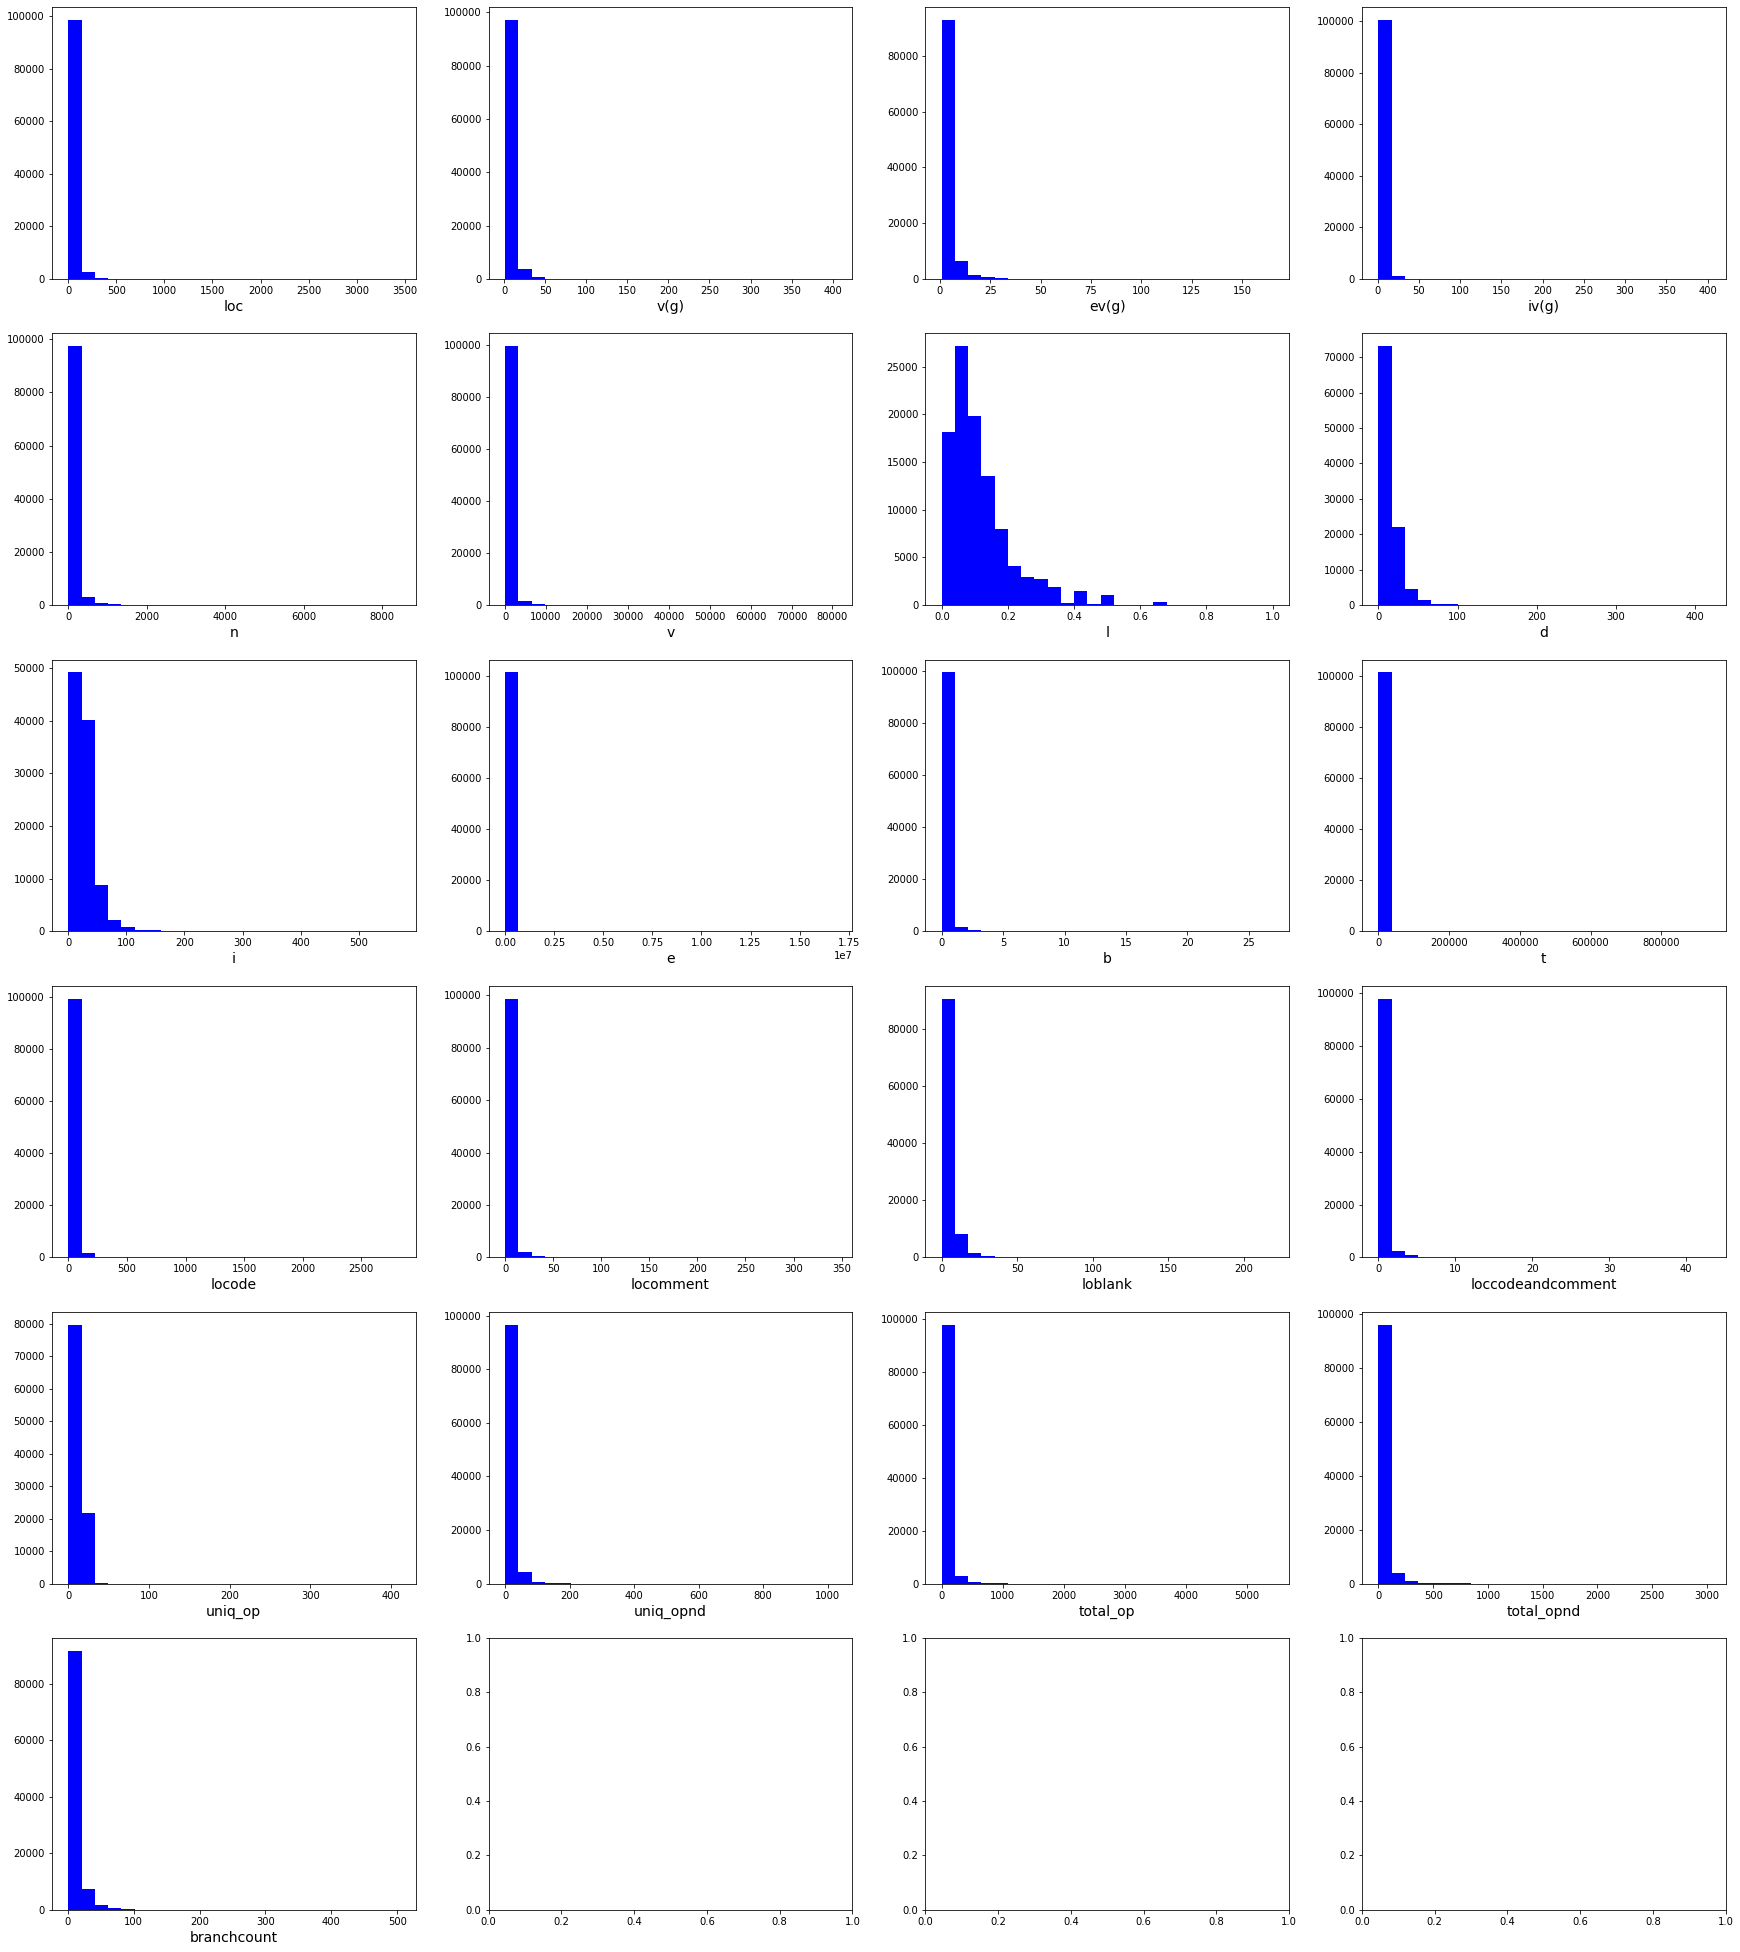

In [24]:
fig, axes = plt.subplots(6, 4,figsize=(30, 35))

for num, feature in enumerate(features):
    data_plot = train[feature].copy()
#     print(axes)
    axes[num//4, num%4].hist(data_plot, bins=25, color="blue")
    axes[num//4, num%4].set_xlabel(feature, fontsize=14)

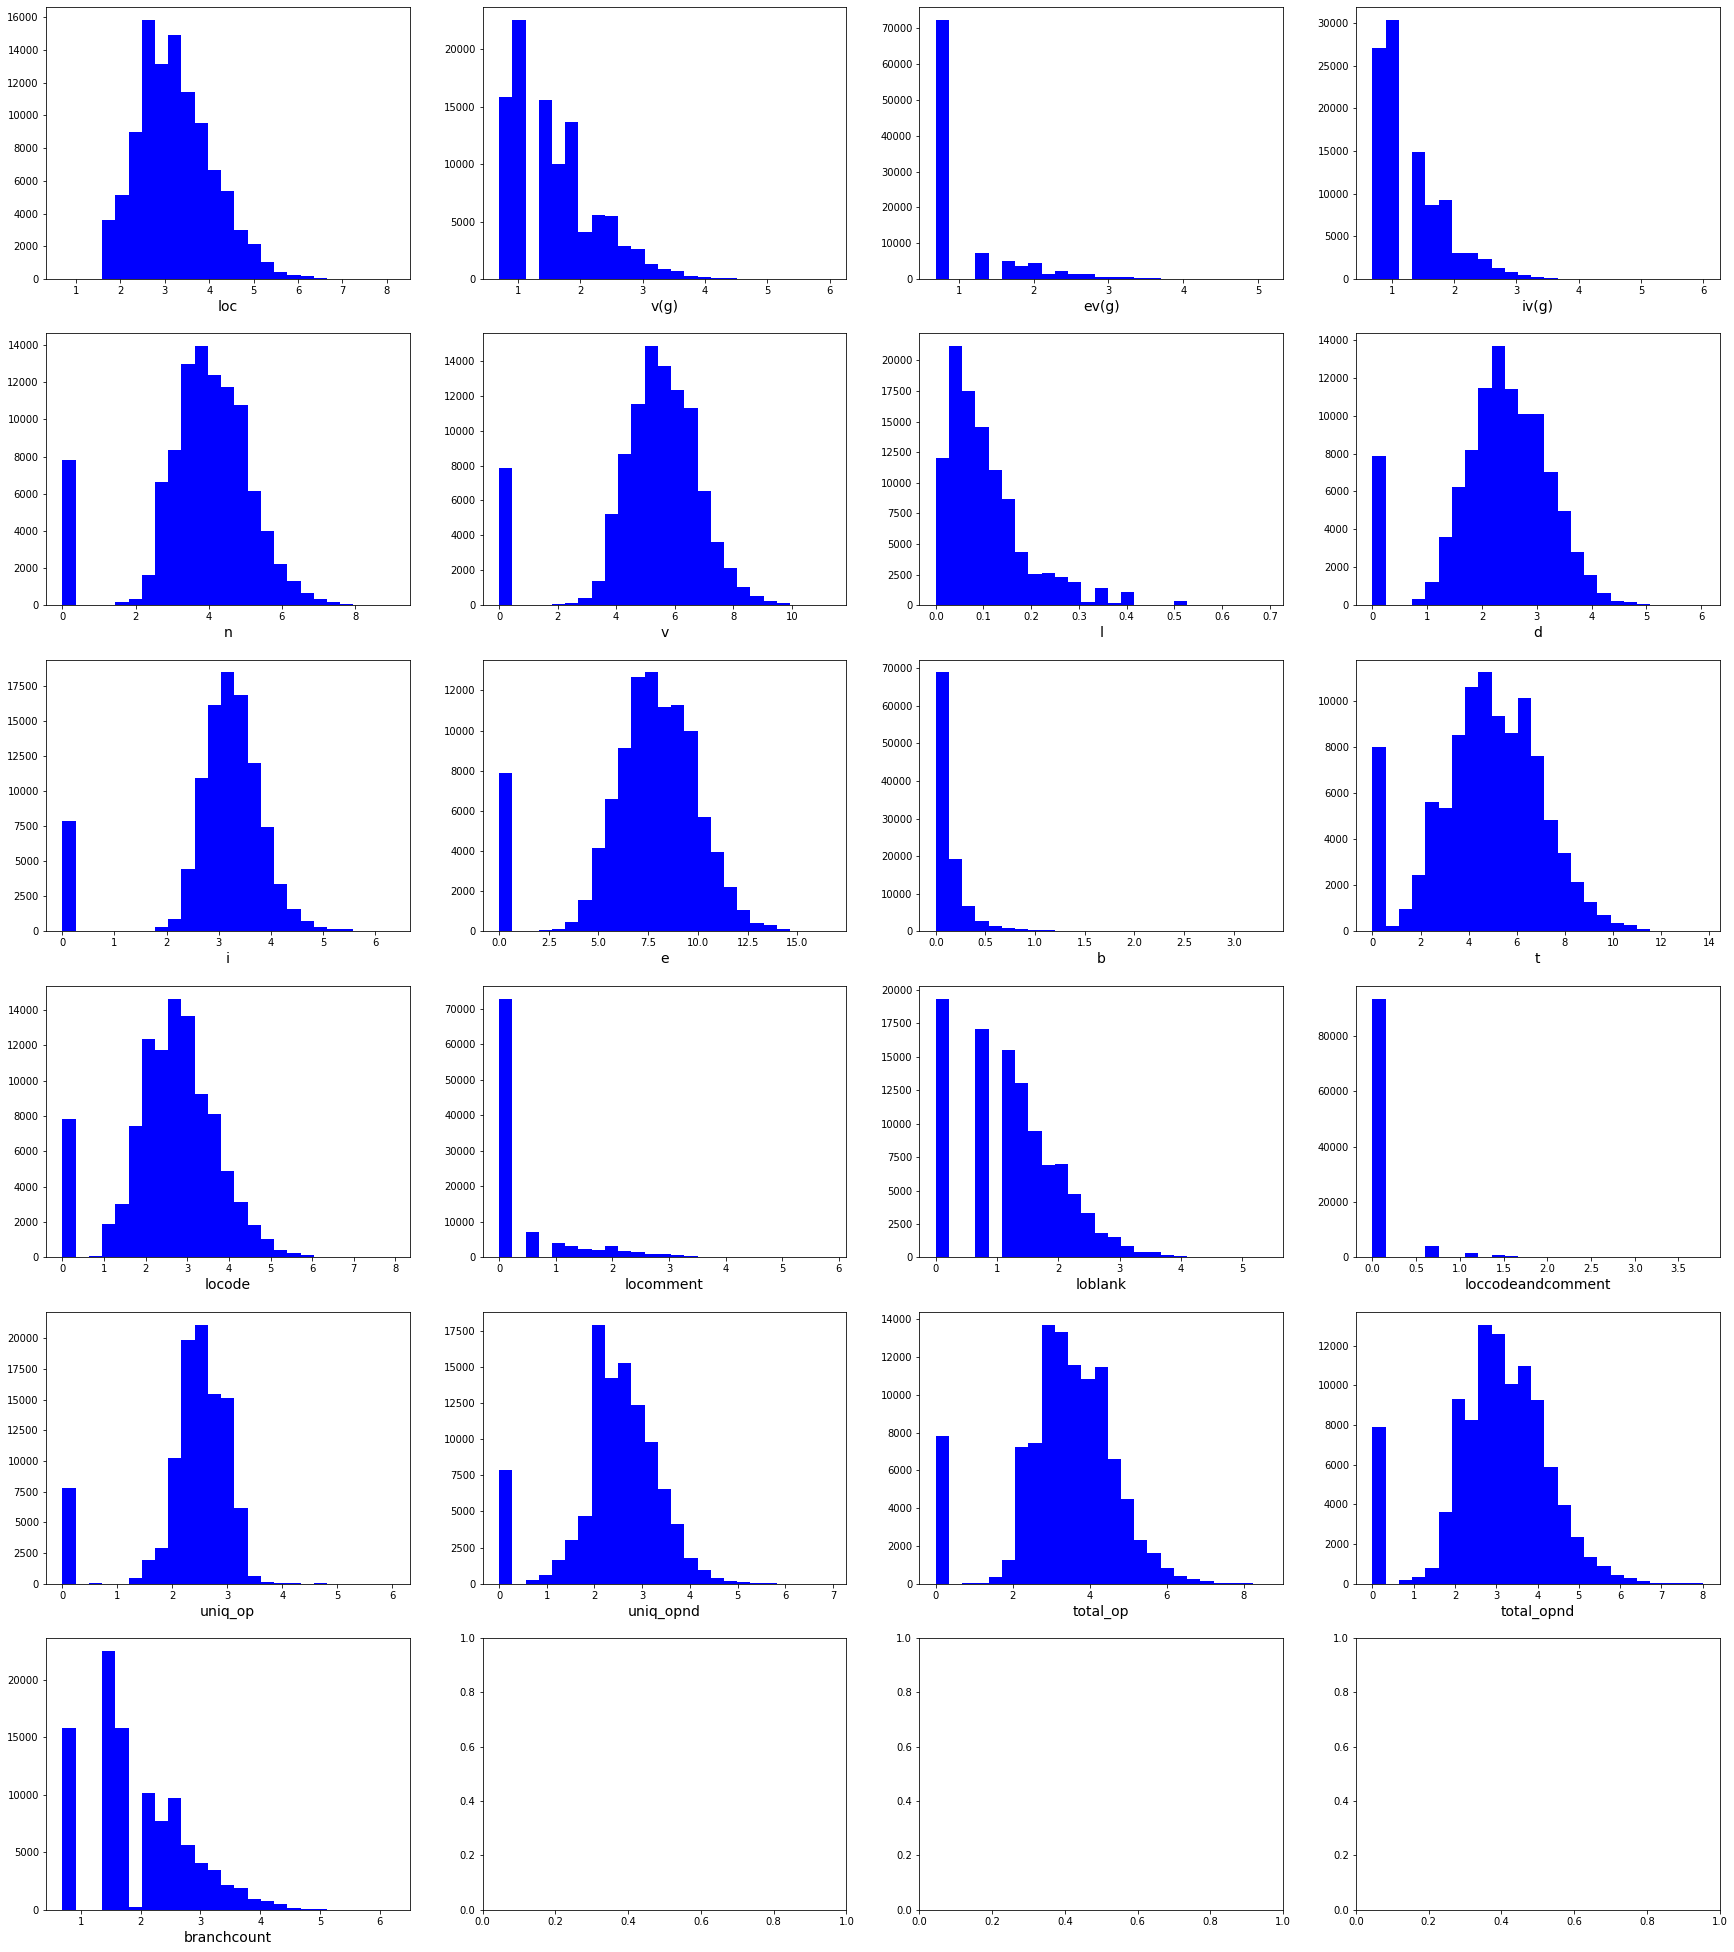

In [26]:
fig, axes = plt.subplots(6, 4,figsize=(30, 35))

for num, feature in enumerate(features):
    data_plot = train[feature].copy()
#     print(axes)
    axes[num//4, num%4].hist(np.log(data_plot + 1), bins=25, color="blue")
    axes[num//4, num%4].set_xlabel(feature, fontsize=14)

# обучение на логарифмированных данных

In [39]:
data_st = train.copy()

In [40]:
for i in data_st.columns:
    data_st[i] = np.log(data_st[i] +1)

In [41]:
train.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,locode,locomment,loblank,loccodeandcomment,uniq_op,uniq_opnd,total_op,total_opnd,branchcount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,1
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,0


In [42]:
data_st.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,locode,locomment,loblank,loccodeandcomment,uniq_op,uniq_opnd,total_op,total_opnd,branchcount,defects
0,3.135494,1.386294,0.693147,1.098612,4.110874,5.633467,0.058269,3.023347,2.724580,8.603332,...,2.890372,0.693147,0.693147,0.0,2.833213,2.302585,3.663562,3.135494,1.791759,0.000000
1,2.708050,1.098612,0.693147,1.098612,3.496508,5.025655,0.131028,2.079442,3.096030,6.843441,...,2.484907,0.000000,0.693147,0.0,2.484907,2.484907,2.944439,2.708050,1.386294,0.000000
2,2.484907,1.098612,0.693147,1.098612,3.828641,5.291544,0.104360,2.202765,3.168003,7.470230,...,2.197225,0.000000,0.693147,0.0,2.564949,2.484907,3.367296,2.890372,1.386294,0.000000
3,2.197225,0.693147,0.693147,0.693147,3.178054,4.553982,0.173953,1.832581,2.937043,6.162599,...,1.609438,0.000000,1.098612,0.0,2.197225,1.945910,2.833213,2.079442,0.693147,0.693147
4,2.484907,1.098612,0.693147,1.098612,2.890372,4.126166,0.165514,1.891605,2.598235,5.904462,...,2.079442,0.000000,1.098612,0.0,2.079442,1.945910,2.397895,2.397895,1.386294,0.000000


In [44]:
data_st['defects'] = train['defects']

In [45]:
x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(data_st, "defects", RandomState=0)

x_train.shape: (65128, 21) x_valid.shape:  (20353, 21) y_train.shape:  (65128,) y_valid.shape:  (20353,) x_test.shape:  (16282, 21) y_test.shape:  (16282,)


In [49]:
model, auc = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=cb_params)
sub(model, test, test_id, "log")

[]
roc_auc_score:  0.6689870252457089
confusion_matrix:  [[14817   936]
 [ 2772  1828]]
accuracy_score:  0.8178155554463715


# Сильно упал score c логарифмироваными данными

Mean-target: 0.2266


c:\program files\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\program files\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\program files\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Index')

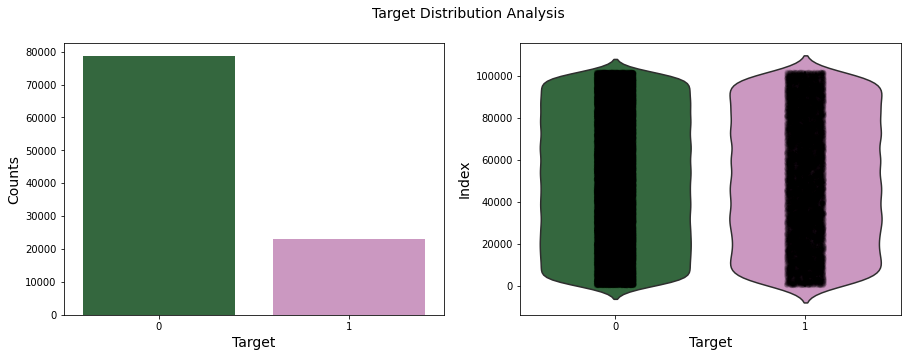

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Target Distribution Analysis", size=14)
print(f"Mean-target: {round(train.defects.mean(), 4)}")

sns.countplot(train.defects, ax=axes[0], palette="cubehelix")
sns.violinplot(train.defects, train.index, ax=axes[1], palette="cubehelix")
sns.stripplot(train.defects, train.index, jitter=True, ax=axes[1], color="black", alpha=0.05)

axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Counts", fontsize=14)
axes[1].set_xlabel("Target", fontsize=14)
axes[1].set_ylabel("Index", fontsize=14)

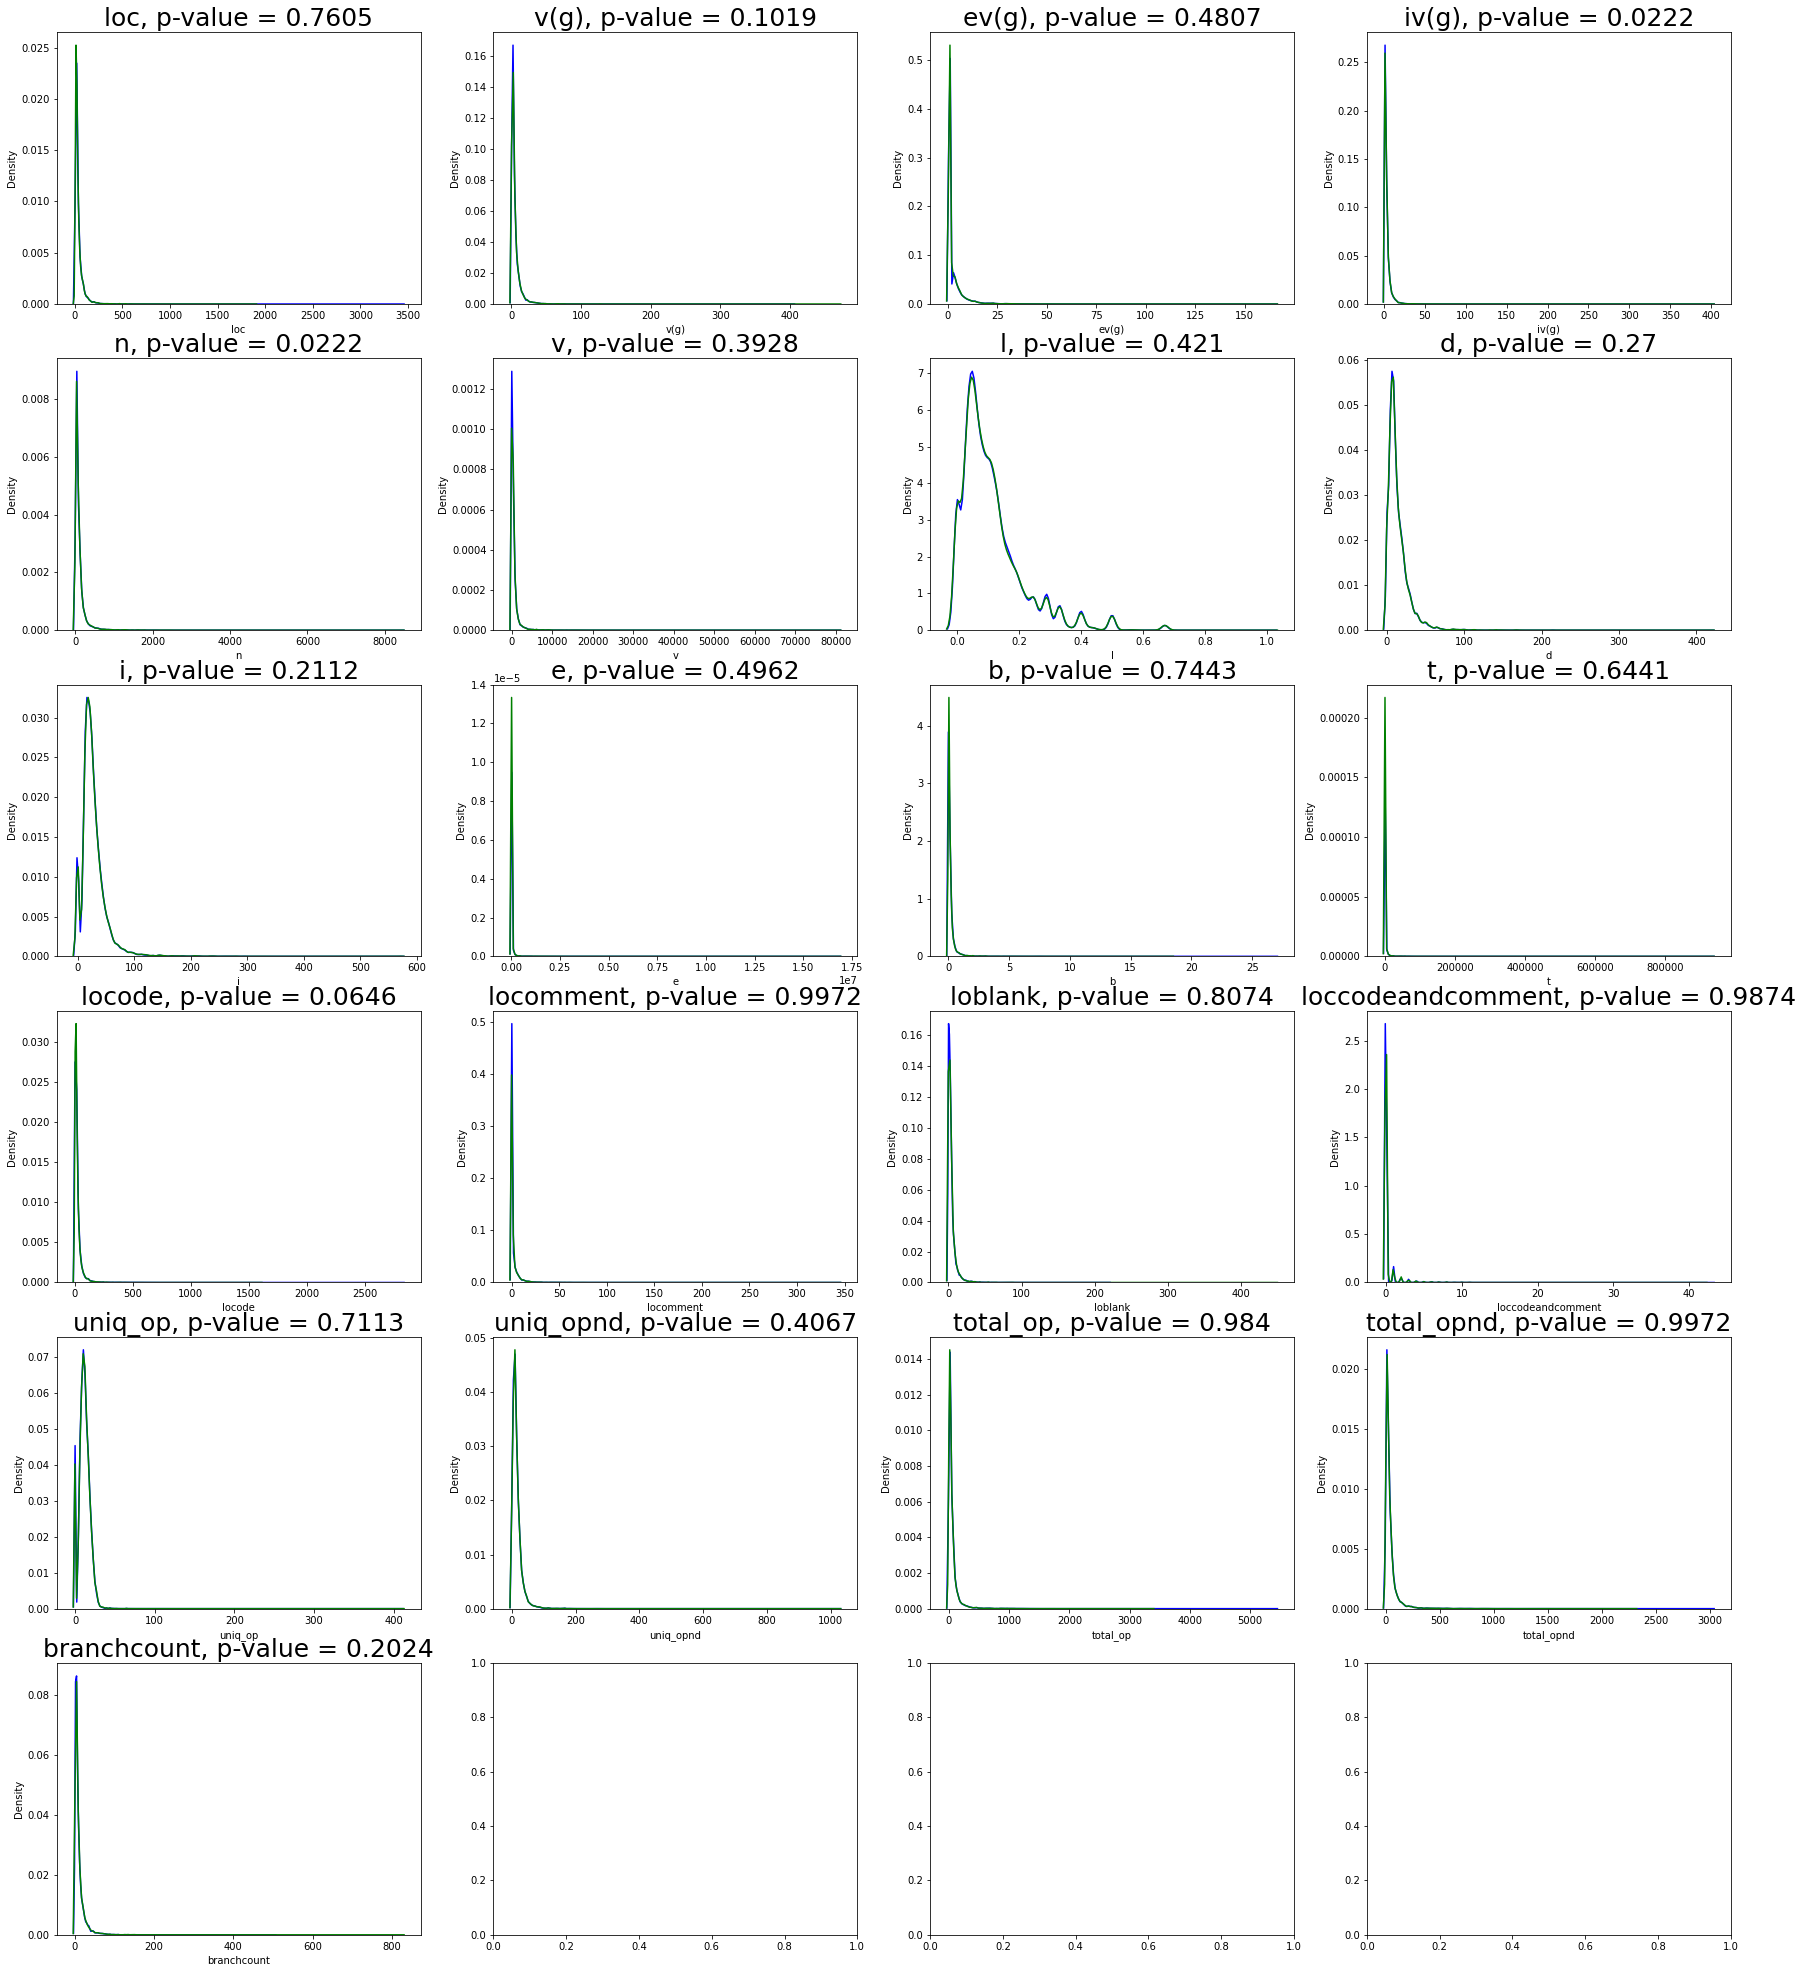

In [101]:
fig, axes = plt.subplots(6, 4, figsize=(30, 35))

for num, feature in enumerate(features):
    try:
        statistic, pvalue = ks_2samp(train[feature].sample(5000), test[feature].sample(5000))
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num%4].set_title(f"{feature}, p-value = {round(pvalue, 4)}", fontsize=25)

c:\program files\python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\program files\python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


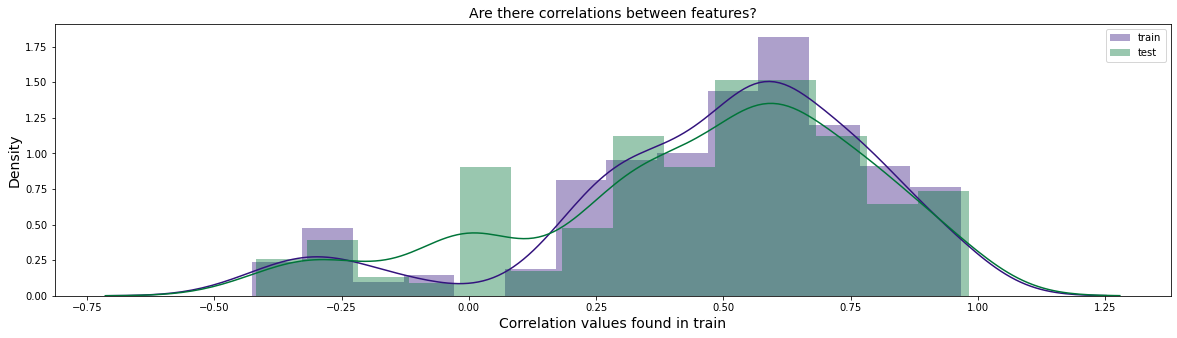

In [28]:
train_correlations = train.drop(["defects"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="#33137d", label="train")
sns.distplot(test_correlations, color="#007539", label="test")
plt.title("Are there correlations between features?", size=14)
plt.xlabel("Correlation values found in train", size=14)
plt.ylabel("Density", size=14)
plt.legend()

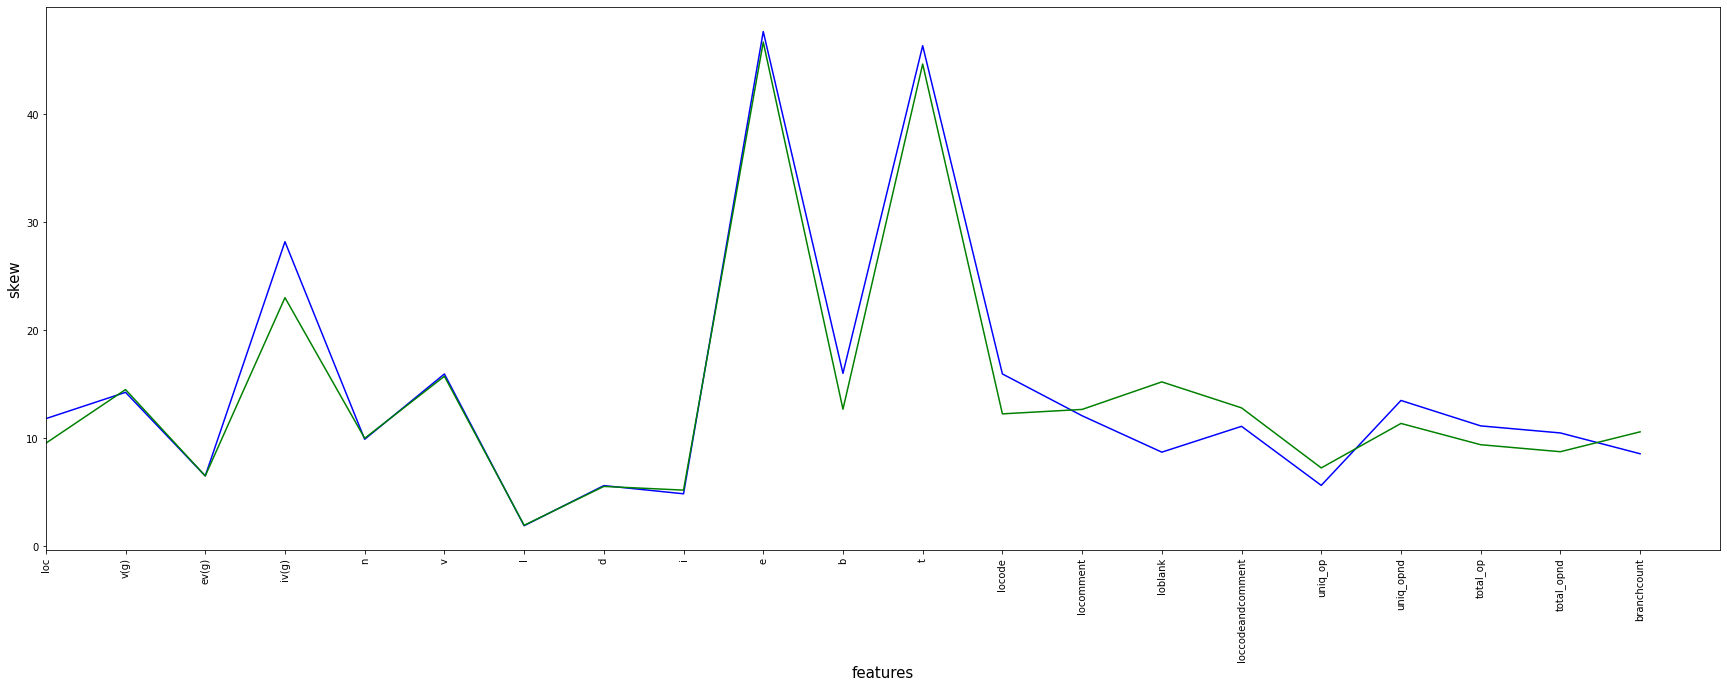

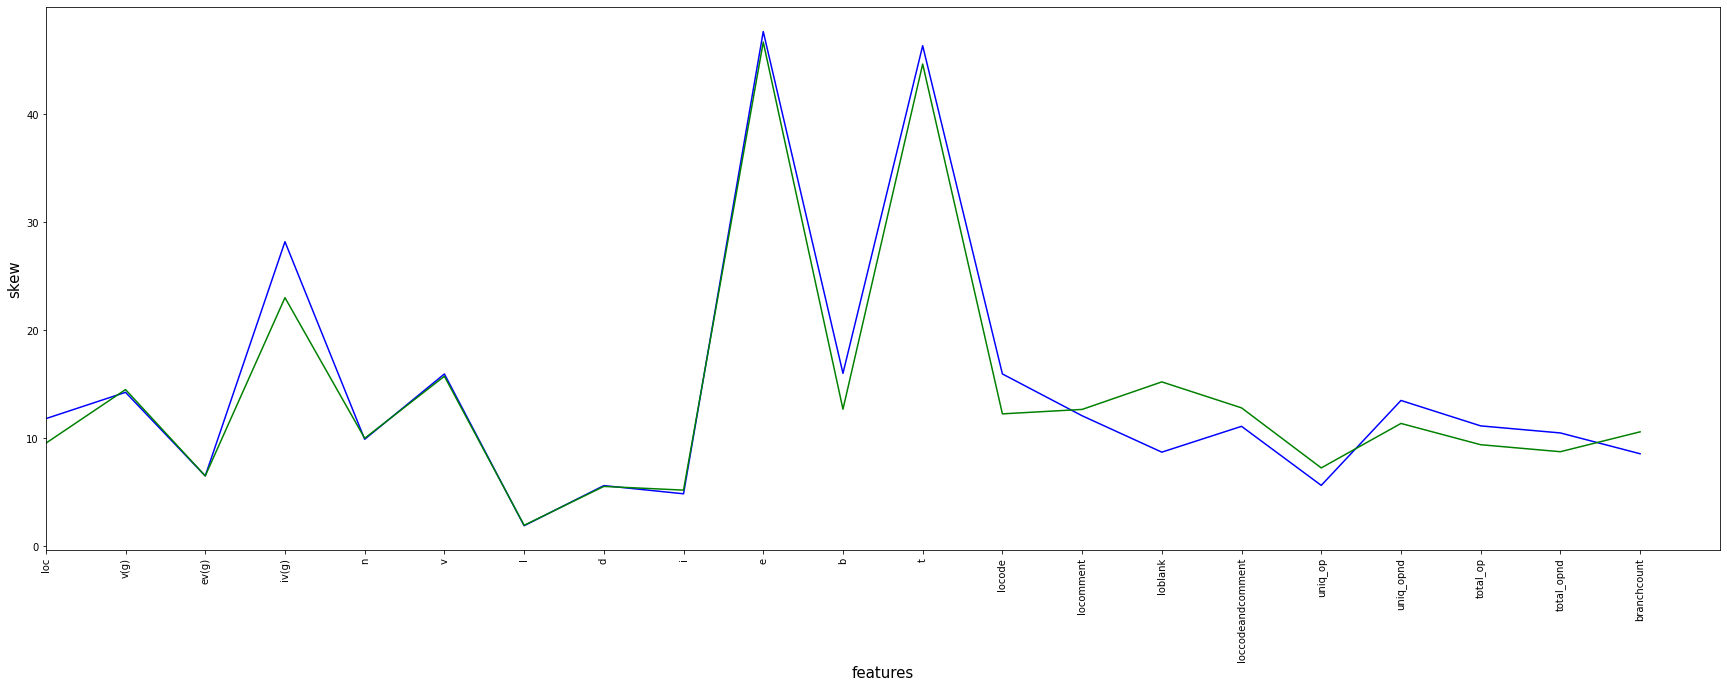

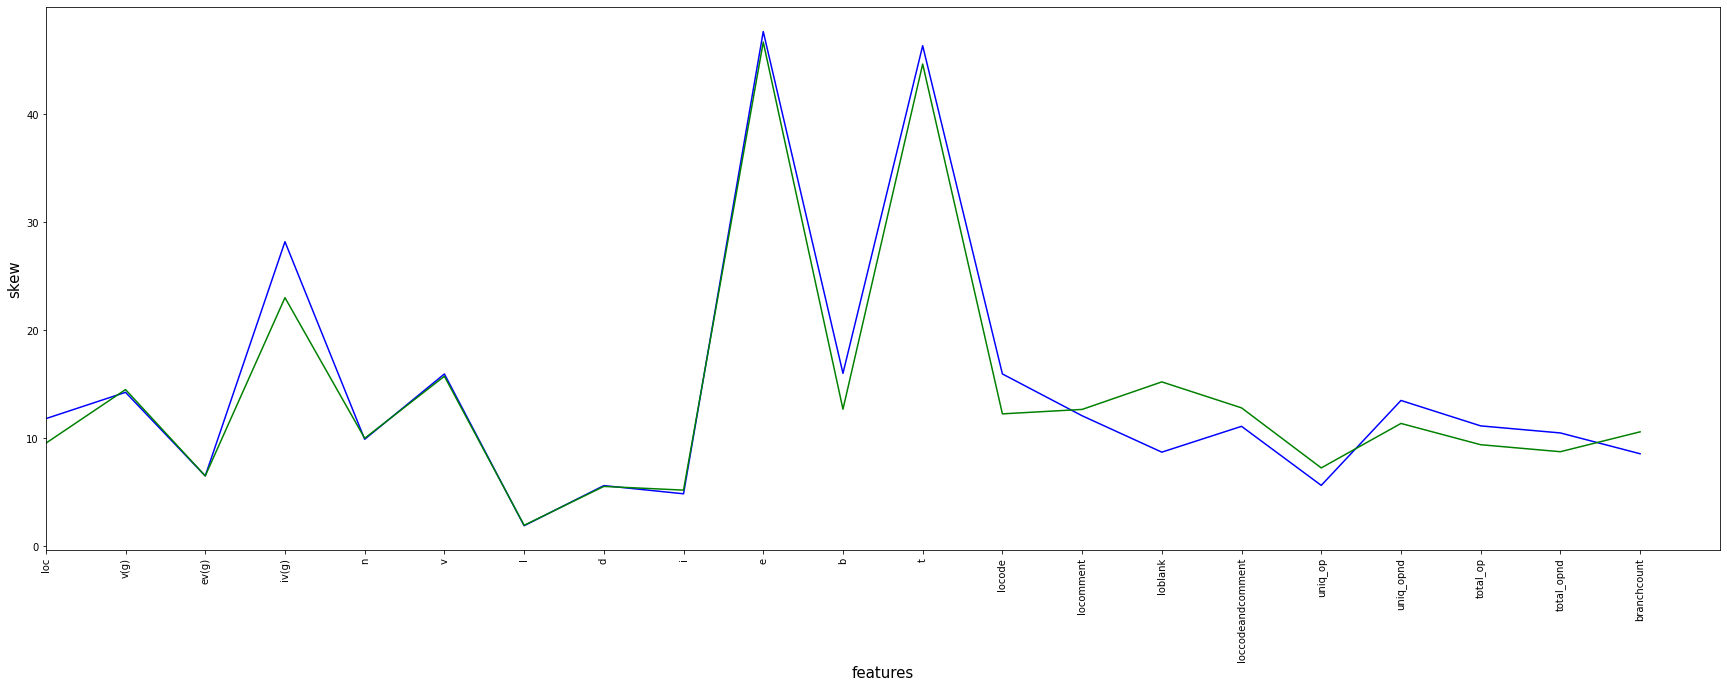

In [32]:
count_max = 10
count_min = 0
for i in range(len(features)):
    if i % 10 == 0:
        col = features
        fig = plt.figure(figsize=(30, 10))
        train_stats, test_stats = train[col].skew(), test[col].skew()
        plt.plot(train_stats, color="blue", label="train")
        plt.plot(test_stats, color="green", label="test")
        plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
        plt.xlabel("features", size=15)
        plt.xlim(0, len(train_stats))
        plt.ylabel("skew", size=15)
        plt.show()
        count_min +=10
        count_max +=10

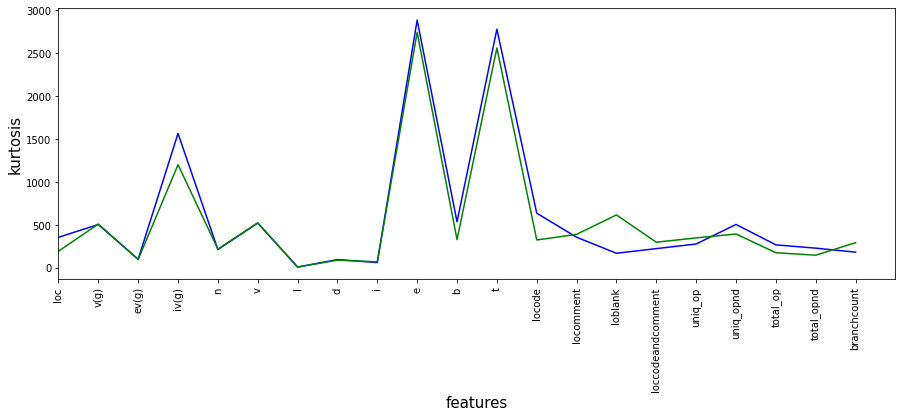

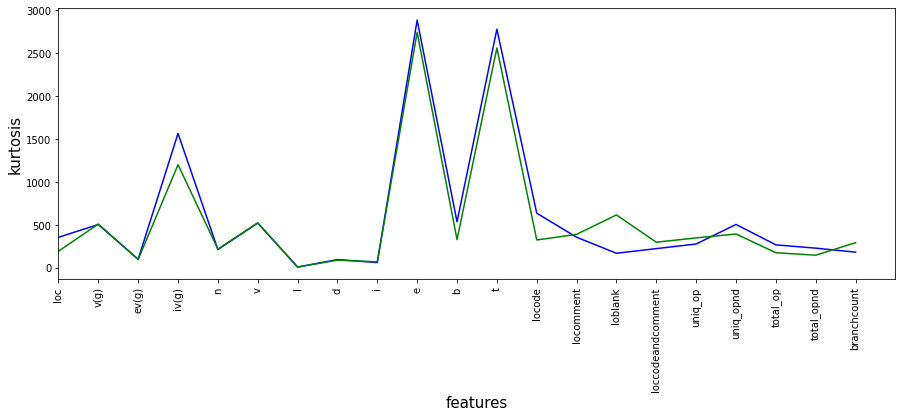

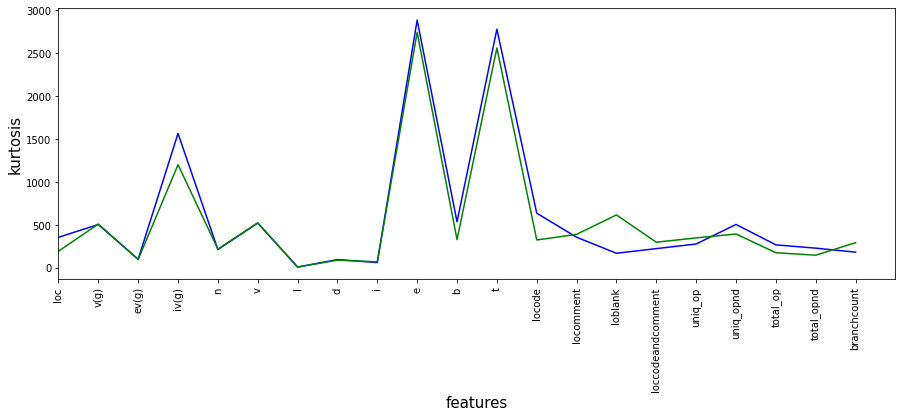

In [33]:
count_max = 10
count_min = 0
for i in range(len(features)):
    if i % 10 == 0:
        col = features
        fig = plt.figure(figsize=(15, 5))
        train_stats, test_stats = train[col].kurtosis(), test[col].kurtosis()
        plt.plot(train_stats, color="blue", label="train")
        plt.plot(test_stats, color="green", label="test")
        plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
        plt.xlabel("features", size=15)
        plt.ylabel("kurtosis", size=15)
        plt.xlim(0, len(train_stats))
        plt.show()

In [90]:
data.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,locode,locomment,loblank,loccodeandcomment,uniq_op,uniq_opnd,total_op,total_opnd,branchcount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,1
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,0


In [95]:
df = data.copy()
df = df.drop(["locode", "loblank"], axis=1)

In [96]:
x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(df, "defects", RandomState=0)

x_train.shape: (65128, 19) x_valid.shape:  (20353, 19) y_train.shape:  (65128,) y_valid.shape:  (20353,) x_test.shape:  (16282, 19) y_test.shape:  (16282,)


In [97]:
model, auc = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=cb_params)
sub(model, test, test_id, "drop_2_feature_stats")

[]
roc_auc_score:  0.6678135358620443
confusion_matrix:  [[14804   949]
 [ 2779  1821]]
accuracy_score:  0.8168328993268805


In [111]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,loc,46.149847
1,v,9.131122
2,l,7.228201
3,uniq_opnd,7.057510
4,i,6.665511
5,branchcount,6.370018
6,uniq_op,4.753736
7,iv(g),4.282282
8,d,2.575766
9,ev(g),2.363998
